In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState
import joblib

In [2]:
device = "cuda"
Epochs = 20
classes = 10

In [3]:
t = transforms.Compose([transforms.ToTensor(),
                        
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                        
                        transforms.Lambda(lambda x : x.permute(1, 2, 0).reshape(-1))
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = datasets.SVHN(root="./data", split="train", transform= t, target_transform=target_t, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform= t, target_transform=target_t, download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [4]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


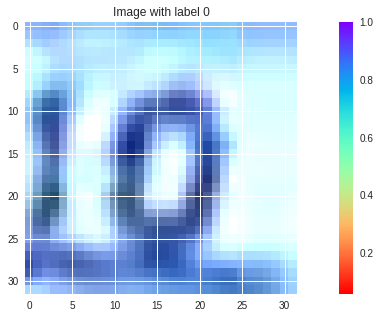

In [120]:
img = next(iter(test_loader))[0][3].reshape(32,32,3)
label = torch.argmax(next(iter(test_loader))[1][3])

def visual(img, label):    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img.numpy() / 2 + 0.5
    im = ax.imshow(img, cmap=plt.cm.rainbow_r)
    fig.colorbar(im)
    ax.set_title(f"Image with label {label}")

visual(img, label)

In [6]:
#defining the model 

def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 4)
    
    layers = []
    
    in_features = 3 * 32 * 32
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_layer{i}", 256, 1024)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
        in_features = out_features
    layers.append(nn.Linear(in_features, classes))
    layers.append(nn.LogSoftmax(dim=1))
    
    return nn.Sequential(*layers)

In [9]:
def objective(trial):
    
    model = define_model(trial).to(device)
#     model = Network().to(device)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    
    #training
    for epoch in range(Epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
        #validation
        model.eval()
        total_corr = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                
                data, target = data.to(device), target.type(torch.float32).to(device)
                output = model(data)
                pred = torch.argmax(output, dim=1)
                
                gt = torch.argmax(target, dim=1)
                correct = torch.count_nonzero(pred == gt)
                total_corr += correct
        accuracy = (total_corr/len(test_dataset))
        
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

[I 2021-11-17 14:36:35,516] A new study created in memory with name: no-name-2b634213-afc7-4494-8137-3c345e7e336f
[I 2021-11-17 14:41:49,669] Trial 0 finished with value: 0.8004379272460938 and parameters: {'n_layers': 3, 'n_units_layer0': 476, 'n_units_layer1': 385, 'n_units_layer2': 686, 'optimizer': 'RMSprop', 'lr': 0.0003851733744785488}. Best is trial 0 with value: 0.8004379272460938.
[I 2021-11-17 14:47:04,930] Trial 1 finished with value: 0.839389979839325 and parameters: {'n_layers': 2, 'n_units_layer0': 732, 'n_units_layer1': 824, 'optimizer': 'Adam', 'lr': 8.245230086283657e-05}. Best is trial 1 with value: 0.839389979839325.
[I 2021-11-17 14:52:21,023] Trial 2 finished with value: 0.6560771465301514 and parameters: {'n_layers': 3, 'n_units_layer0': 416, 'n_units_layer1': 654, 'n_units_layer2': 817, 'optimizer': 'RMSprop', 'lr': 0.0015314516436458468}. Best is trial 1 with value: 0.839389979839325.
[I 2021-11-17 14:57:34,634] Trial 3 finished with value: 0.8211432099342346 an

[I 2021-11-17 16:49:37,459] Trial 66 pruned. 
[I 2021-11-17 16:51:13,169] Trial 67 pruned. 
[I 2021-11-17 16:51:29,267] Trial 68 pruned. 
[I 2021-11-17 16:51:45,446] Trial 69 pruned. 
[I 2021-11-17 16:52:01,601] Trial 70 pruned. 
[I 2021-11-17 16:52:33,544] Trial 71 pruned. 
[I 2021-11-17 16:53:05,605] Trial 72 pruned. 
[I 2021-11-17 16:53:37,438] Trial 73 pruned. 
[I 2021-11-17 16:54:08,885] Trial 74 pruned. 
[I 2021-11-17 16:54:25,128] Trial 75 pruned. 
[I 2021-11-17 16:54:57,702] Trial 76 pruned. 
[I 2021-11-17 16:55:13,816] Trial 77 pruned. 
[I 2021-11-17 16:55:29,812] Trial 78 pruned. 
[I 2021-11-17 16:55:45,613] Trial 79 pruned. 
[I 2021-11-17 16:56:01,600] Trial 80 pruned. 
[I 2021-11-17 16:56:33,488] Trial 81 pruned. 
[I 2021-11-17 16:56:49,423] Trial 82 pruned. 
[I 2021-11-17 16:57:37,680] Trial 83 pruned. 
[I 2021-11-17 16:57:53,881] Trial 84 pruned. 
[I 2021-11-17 16:58:10,000] Trial 85 pruned. 
[I 2021-11-17 16:58:26,016] Trial 86 pruned. 
[I 2021-11-17 16:58:42,021] Trial 

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  79
  Number of complete trials:  21


### Saving and loading optuna study

In [30]:
# joblib.dump(study, "study_1.pkl")

study = joblib.load("study_1.pkl")

best_trial = study.best_trial

best_params = best_trial.params
print(best_params)

{'n_layers': 2, 'n_units_layer0': 732, 'n_units_layer1': 824, 'optimizer': 'Adam', 'lr': 8.245230086283657e-05}


In [31]:
# defining a new model with the same params as optuna optimized for us

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dims = 3072
        self.layer1 = nn.Linear(in_features=3072, out_features=732)
        self.layer2 = nn.Linear(in_features=732, out_features=824)
        self.layer3 = nn.Linear(in_features=824, out_features=10)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        
        x = self.layer3(x)
        pred = F.log_softmax(x, dim=1)
        return x


In [67]:
#define a new model for these values:

best_model = Network().to(device)

criterion = nn.CrossEntropyLoss().to(device)

lr = best_params['lr']
optimizer = getattr(optim, best_params['optimizer'])(best_model.parameters(), lr=lr)


def testing(model):
    model = model.to(device)
    model.eval()
    total_corr = 0
    loss = []
    with torch.no_grad():
        total_corr = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = model(data)
            
            batch_loss = criterion(output, target)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
            loss.append(batch_loss.item())
            
    accuracy = (total_corr/len(test_dataset))
    
    return accuracy, np.mean(loss)


def training(Epochs, model):
    accuracy_list = []
    loss_list= []
    loss_hist  = []
    norm_list = []
    param_name = []
    val_loss_list = []
    
    for epoch in range(Epochs):
        model.train()
        
        cur_loss_list = []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (data, target) in progress_bar:
            total_norm=0

            data, target = data.to(device), target.type(torch.float32).to(device)
            output = model(data)
            loss = criterion(output, target)
            cur_loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for par in model.parameters():
                par_norm = par.grad.data.norm(2)
                total_norm += par_norm.item() ** 2
            total_norm = total_norm ** (0.5)
            norm_list.append(total_norm)
            
            if(batch_idx % 5 == 0):
                progress_bar.set_description(f"Epoch {epoch+1} Iter {batch_idx+1}: loss {loss.item():.5f}. ")
        
        acc, val_loss = testing(model)

        accuracy_list.append(acc.item())
        val_loss_list.append(val_loss)
        
        loss_list = loss_list + cur_loss_list        
        loss_hist.append(np.mean(cur_loss_list))
    return loss_list, loss_hist, norm_list, accuracy_list, val_loss_list


loss_list, loss_hist, norm_list, accuracy_list, val_loss_list = training(Epochs, best_model)

Epoch 20 Iter 141: loss 0.35543. : 100%|██████| 144/144 [00:12<00:00, 11.49it/s]


In [122]:
#Saving the model for assignmnet 3

save_path = "best_model.pth"
torch.save({
    'model_state_dict' : best_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, save_path)

### Visualizing Training Loss

In the first plot given below are the training loss and the validation loss for each epoch. It can be seen that both training and val loss are decreasing nicely in the beginning suggesting that model is getting well trained. But after epoch 7 validation loss plateaued and training loss kept decreasing which shows that model is overfitting on the training data and has stopped generalizing

In the second plot the training loss per iteration is shown, this shows the fluctuations in the loss value while training each batch. 

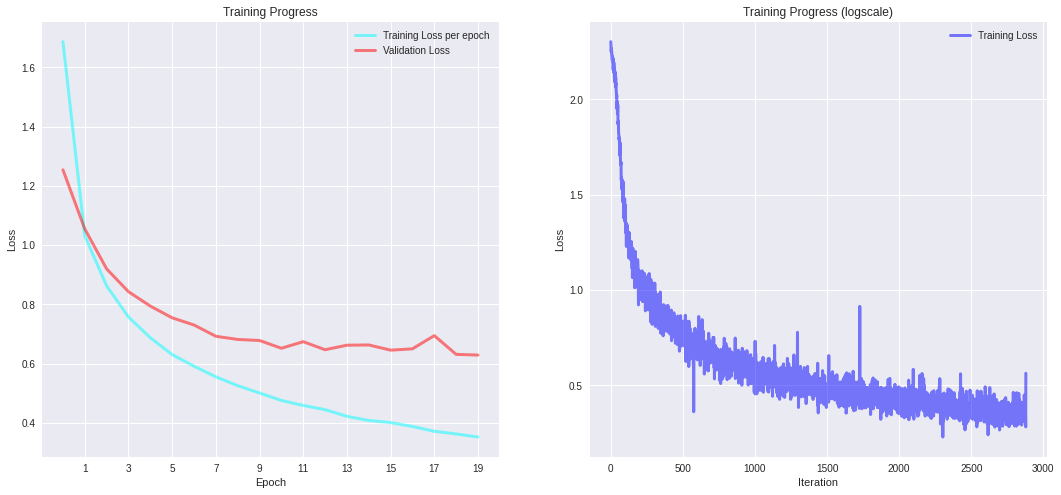

In [109]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 8)

ax[0].plot(loss_hist, c="cyan", label="Training Loss per epoch", linewidth=3, alpha=0.5)
ax[0].plot(val_loss_list, label="Validation Loss", c='red', linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training Progress")
ax[0].set_xticks(np.arange(1, 21, step=2))

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Progress (logscale)")

plt.show()

### Visualizing Accuracy and Norms of Grads

In the first plot below the rise of accuracy can be seen, this shows that the model has a steep learning curve in the beginning and plateaues towards the end of training 

The second plot is of the norm of gradients during training. This plot is quite unique it shows that how in some iterations the norm of the gradients was quite high which is not good for training. If we could clip these grads or used a normalizer then it would have been better for training and the overfitting issue that we observed in the first plot would have been less prominent

Text(0.5, 1.0, 'Norm of gradients')

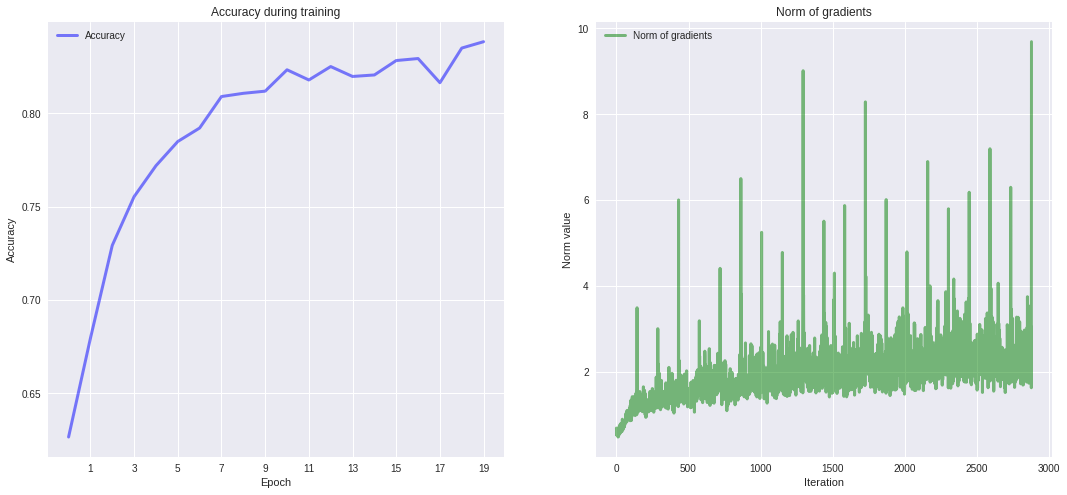

In [111]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 8)

ax[0].plot(accuracy_list, c="blue", label="Accuracy", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy during training")
ax[0].set_xticks(np.arange(1, 21, step=2))


ax[1].plot(norm_list, c="green", label="Norm of gradients", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Norm value")
ax[1].set_title("Norm of gradients")


In [112]:
def confusion_mat_testing(test_loader, net):
    best_model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = best_model(data)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            preds.append(pred)
            labels.append(gt)
            
    return torch.cat(preds), torch.cat(labels)

preds, labels = confusion_mat_testing(test_loader, best_model)

### Confusion matrix

The plot below is the confusion matrix which is a plot of how good the classification was per class i.e. what samples were classifed really good (which has high score along the diagonals in the matrix below). The elements in the diagonal are the True Positives for that perticular class. 

Here we can see that the ones, twos have a pretty high score, followed by fours, sevens and nines.

One thing that has to be noted that the values are normalized along the rows, thus between true positives vs false positives.

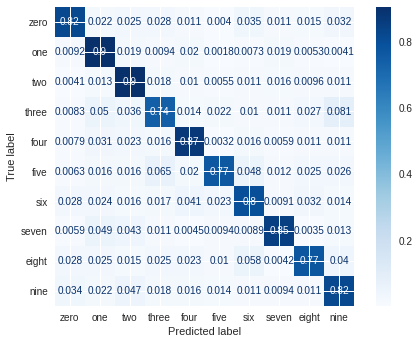

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay

CLASSES= ['zero','one','two','three','four','five','six','seven','eight','nine']
 
classes = np.array(CLASSES, dtype='str')

# ConfusionMatrixDisplay.from_predictions(cf,display_labels=classes,cmap=plt.cm.Blues,normalize=normalize).plot()
ConfusionMatrixDisplay.from_predictions(labels.to("cpu"), preds.to("cpu"),display_labels=classes, normalize='true', cmap=plt.cm.Blues)